<a href="https://colab.research.google.com/github/kunwarsharik/SharikProjects/blob/master/CUDA_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os,sys,glob,matplotlib.pyplot as plt, numpy as np, pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [0]:
from IPython.display import HTML, Image
from timeit import default_timer as timer

In [0]:
#cuda only for nvidia, opencl for all

In [4]:
!pip install numba

In [0]:
from numba import cuda, vectorize, guvectorize
import numba.cuda.api,numba.cuda.cudadrv.libs
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import numpy as np

In [6]:
numba.cuda.cudadrv.libs.test()
numba.cuda.api.detect()

Finding cublas from System
	located at /usr/local/cuda/lib64/libcublas.so.10.0.130
	trying to open library...	ok
Finding cusparse from System
	located at /usr/local/cuda/lib64/libcusparse.so.10.0.130
	trying to open library...	ok
Finding cufft from System
	located at /usr/local/cuda/lib64/libcufft.so.10.0.145
	trying to open library...	ok
Finding curand from System
	located at /usr/local/cuda/lib64/libcurand.so.10.0.130
	trying to open library...	ok
Finding nvvm from System
	located at /usr/local/cuda/nvvm/lib64/libnvvm.so.3.3.0
	trying to open library...	ok
Finding libdevice from System
	searching for compute_20...	ok
	searching for compute_30...	ok
	searching for compute_35...	ok
	searching for compute_50...	ok
Found 1 CUDA devices
id 0    b'Tesla P100-PCIE-16GB'                              [SUPPORTED]
                      compute capability: 6.0
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

In [0]:
@cuda.jit('void(float32[:], float32[:], float32[:])')
def cu_add1(a, b, c):
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x
    tx = cuda.threadIdx.x
    i = tx + bx * bw
    if i > c.size:
        return
    c[i] = a[i] + b[i]

In [0]:
device = cuda.get_current_device()

In [9]:
n=100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)

da = cuda.to_device(a)
db = cuda.to_device(b)

dc = cuda.device_array_like(a)
tpb = device.WARP_SIZE
bpg = int(np.ceil(float(n)/tpb))

print ('Blocks per grid:', bpg,' Threads per block: ', tpb)

cu_add1[bpg, tpb](da, db, dc)

c = dc.copy_to_host()
print(c)

Blocks per grid: 4  Threads per block:  32
[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198.]


In [0]:
@cuda.jit('void(float32[:], float32[:], float32[:])')
def cu_add2(a, b, c):
    i  = cuda.grid(1)
    if i > c.shape[0]:
        return
    c[i] = a[i] + b[i]

In [11]:
device = cuda.get_current_device()
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)
c = np.empty_like(a)
tpb = device.WARP_SIZE
bpg = int(np.ceil(float(n)/tpb))
print ('Blocks per grid:', bpg,' Threads per block: ', tpb)
cu_add2[bpg, tpb](a, b, c)
print(c)

Blocks per grid: 4  Threads per block:  32
[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198.]


In [0]:
#4 type of decorator jit cudajit vectorize guvectorize
@vectorize(['int64(int64, int64)','float32(float32, float32)','float64(float64, float64)'],target='cuda')
def cu_add(a, b):
    return a + b

In [13]:
n = 100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)
c = cu_add(a, b)
print(c)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198.]


In [0]:
#2D grid
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:])')
def cu_add_2d(a, b, c):    
    i, j  = cuda.grid(2)
    if (i < c.shape[0]) and (j < c.shape[1]):
        c[i, j] = a[i, j] + b[i, j]
    cuda.syncthreads()

In [15]:
device = cuda.get_current_device()
n = 480
p = 320
a = np.random.random((n, p)).astype(np.float32)
b = np.ones((n, p)).astype(np.float32)
c = np.empty_like(a)
threadsperblock = (16, 16)
blockspergrid_x = (n + threadsperblock[0]) // threadsperblock[0]
blockspergrid_y = (p + threadsperblock[1]) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)
print(blockspergrid, threadsperblock)
cu_add_2d[blockspergrid, threadsperblock](a, b, c)
print(c)

(31, 21) (16, 16)
[[1.1289 1.7223 1.4686 ... 1.927  1.1292 1.5802]
 [1.9922 1.6129 1.4926 ... 1.3285 1.8422 1.4132]
 [1.3622 1.7965 1.9497 ... 1.0957 1.6826 1.3456]
 ...
 [1.3275 1.4555 1.235  ... 1.33   1.8515 1.3372]
 [1.1211 1.3119 1.5653 ... 1.4218 1.785  1.9681]
 [1.5575 1.6793 1.8583 ... 1.1939 1.8583 1.8683]]


In [16]:
#vectorize 2d
@vectorize(['int64(int64, int64)','float32(float32, float32)','float64(float64, float64)'],target='cuda')
def cu_vec_add_2d(a, b):
    return a + b
#vectorize take care of no of bpg,tpb
n = 480
p = 320
a = np.random.random((n, p)).astype(np.float32)
b = np.ones((n, p)).astype(np.float32)
c= cu_vec_add_2d(a, b)

print(a[:5,:5])
print(b[:5,:5])
print(c[:5,:5])

[[0.6398 0.4295 0.0234 0.9317 0.613 ]
 [0.1619 0.1002 0.8847 0.1656 0.2427]
 [0.3313 0.8177 0.5391 0.5699 0.5746]
 [0.886  0.1223 0.3796 0.5578 0.3443]
 [0.5083 0.1083 0.6713 0.2085 0.1861]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1.6398 1.4295 1.0234 1.9317 1.613 ]
 [1.1619 1.1002 1.8847 1.1656 1.2427]
 [1.3313 1.8177 1.5391 1.5699 1.5746]
 [1.886  1.1223 1.3796 1.5578 1.3443]
 [1.5083 1.1083 1.6713 1.2085 1.1861]]


In [0]:
#vectorize also takes of switching execution target.i.e run on a single core, or in parallel on many core it'll manage
@vectorize(['int64(int64, int64)','float32(float32, float32)','float64(float64, float64)'],target='parallel')
def cu_vec_add_2d(a, b):
    return a + b

In [18]:
n = 480
p = 320
a = np.random.random((n, p)).astype(np.float32)
b = np.ones((n, p)).astype(np.float32)
c= cu_vec_add_2d(a, b)

print(a[:5,:5])
print(b[:5,:5])
print(c[:5,:5])

[[0.8872 0.0908 0.026  0.2369 0.8312]
 [0.3322 0.0619 0.4879 0.492  0.5665]
 [0.5158 0.7537 0.9097 0.923  0.476 ]
 [0.9226 0.4795 0.2704 0.8006 0.989 ]
 [0.3029 0.4911 0.7333 0.5506 0.2663]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1.8872 1.0908 1.026  1.2369 1.8312]
 [1.3322 1.0619 1.4879 1.492  1.5665]
 [1.5158 1.7537 1.9097 1.923  1.476 ]
 [1.9226 1.4795 1.2704 1.8006 1.989 ]
 [1.3029 1.4911 1.7333 1.5506 1.2663]]


In [0]:
#sharing can be done by threads using both shared and global memory, but global is very slow and hence avoided.
#shared mem can only be used by threads in block.

In [0]:
#communication across threads, shared memory and sync
@cuda.jit('int32(int32, int32)', device=True)
def dev_sum(a, b):
    return a + b
@cuda.jit('void(int32[:], int32[:])')
def cu_sum(a, b):
    sa = cuda.shared.array(shape=(512,), dtype=int32)
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x
    i = tx + bx * bw
    if i < a.shape[0]:
        sa[tx] = a[i]
        if tx == 0:
            s = sa[tx]
            cuda.syncthreads()
            for j in range(1, bw):
                s = dev_sum(s, sa[j])
            b[bx] = s

In [20]:
k=4
n=6*4
a = np.random.randint(0, n, n).astype(np.int32)
#b = np.random.randint(0, n, n).astype(np.int32)
print ('a =', a)
print ('a.sum() = ', a.sum())
d_a = cuda.to_device(a)
d_b = cuda.to_device(a, copy=False)
griddim = (k, 1)
blockdim = (a.size//k, 1)
cu_sum[griddim, blockdim](d_a, d_a)
d_a.to_host()
print ('a =', a)
cu_sum[1, griddim](d_a[:k], d_a)
d_a.to_host()
print ('a =', a)

a = [ 6 21  6 21  1  4  6  8 12 22  2 16 12 17  0 11 11 12 17  0 13  4 23 11]
a.sum() =  256
a = [59 66 63 68  1  4  6  8 12 22  2 16 12 17  0 11 11 12 17  0 13  4 23 11]
a = [256  66  63  68   1   4   6   8  12  22   2  16  12  17   0  11  11  12
  17   0  13   4  23  11]


In [0]:
#compare Madnelbrot fractal python vs vectorize vs cudajit
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [0]:
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on CPU in 11.912909 s


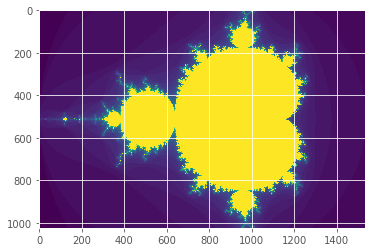

In [23]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.imshow(gimage)

In [0]:
import numba
mandel_numba = numba.jit(uint32(float32, float32, uint32))(mandel)

In [0]:
@numba.jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on CPU in 0.250815 s


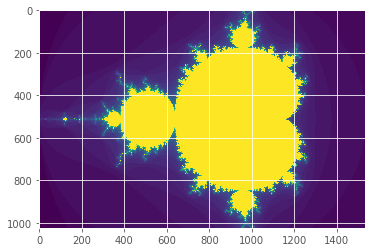

In [26]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print ("Mandelbrot created on CPU in %f s" % dt)
plt.imshow(gimage)

In [0]:
mandel_gpu = cuda.jit(restype=uint32, argtypes=[float32, float32, uint32], device=True)(mandel)

In [0]:
@cuda.jit(argtypes=[float32, float32, float32, float32, uint8[:,:], uint32])
def create_fractal_kernel(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x # stride in x
    gridY = cuda.gridDim.y * cuda.blockDim.y # stride in y

    for x in range(startX, width, gridX):
        real = xmin + x*pixel_size_x
        for y in range(startY, height, gridY):
            imag = ymin + y*pixel_size_y
            color = mandel_gpu(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on GPU in 0.002709 s


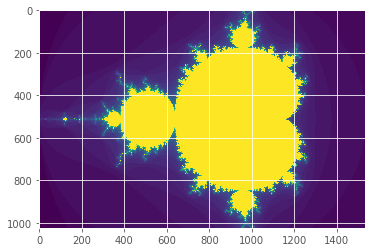

In [29]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
blockdim = (32, 8)
griddim = (32, 16)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
d_image = cuda.to_device(gimage)
create_fractal_kernel[griddim, blockdim](xmin, xmax, ymin, ymax, d_image, iters)
d_image.to_host()
dt = timer() - start

print ("Mandelbrot created on GPU in %f s" % dt)
plt.imshow(gimage);

In [0]:
#no shared mmry
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], int32)')
def cu_matmul(a, b, c, n):
    x, y = cuda.grid(2)
    if (x >= n) or (y >= n):
        return
    c[x, y] = 0
    for i in range(n):
        c[x, y] +=  a[x, i] * b[i, y]
    

In [0]:
tpb = device.WARP_SIZE
n = 400
bpg = (n+tpb-1)//tpb
grid_dim = (bpg, bpg)
block_dim = (tpb, tpb)
A = np.random.random((n, n)).astype(np.float32)
B = np.random.random((n, n)).astype(np.float32)
C = np.empty((n, n), dtype=np.float32)
cu_matmul[grid_dim, block_dim](A, B, C, n)
assert(np.allclose(np.dot(A, B), C))

In [33]:
print(C)

[[ 95.6819 102.6256  97.1412 ...  99.3823  98.0109  96.0428]
 [ 99.4969 107.878  101.9715 ... 101.2091 101.7379 102.2736]
 [ 89.7464  99.7819  95.0523 ...  91.7552  94.3732  94.9066]
 ...
 [ 94.7442 103.4978 100.0931 ...  96.7879  97.0001  98.4568]
 [ 95.295  103.7267  95.8899 ...  98.9058 100.6443  98.4695]
 [ 99.5778 109.9046 102.4656 ... 101.6233  99.2945 101.8121]]


In [0]:
tpb = device.WARP_SIZE
block_dim = (tpb, tpb)
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], int32, int32, int32)')
def cu_matmul_sm(A, B, C, n, tpb, bpg):
    sA = cuda.shared.array(shape=block_dim, dtype=float32)
    sB = cuda.shared.array(shape=block_dim, dtype=float32)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    x, y = cuda.grid(2)
    acc = 0.0
    for i in range(bpg):
        sA[tx, ty] = A[x, ty + i * tpb]
        sB[tx, ty] = B[tx + i * tpb, y]
        cuda.syncthreads()
        if x < n and y < n:
            for j in range(tpb):
                acc += sA[tx, j] * sB[j, ty]
        cuda.syncthreads()
    if x < n and y < n:
        C[x, y] = acc

In [0]:
k = 32
n = tpb * k
bpg = n//tpb
grid_dim = (bpg, bpg)
A = np.random.random((n, n)).astype(np.float32)
B = np.random.random((n, n)).astype(np.float32)
C = np.empty((n, n), dtype=np.float32)
cu_matmul_sm[grid_dim, block_dim](A, B, C, n, tpb, bpg)
assert(np.allclose(np.dot(A, B), C))

In [38]:
k = 8
n = tpb * k
bpg = n//tpb
grid_dim = (bpg, bpg)

# Prepare data on the CPU
A = np.array(np.random.random((n, n)), dtype=np.float32)
B = np.array(np.random.random((n, n)), dtype=np.float32)
C = np.zeros_like(A)

print ("N = %d x %d" % (n, n))

# Prepare data on the GPU
dA = cuda.to_device(A)
dB = cuda.to_device(B)
dC = cuda.to_device(C) # device_array_like(A)

# Time numpy version
s = timer()
np_ans = np.dot(A, B)
e = timer()
t = e - s

# Time the unoptimized version
s = timer()
cu_matmul[grid_dim, block_dim](dA, dB, dC, n)
cuda.synchronize()
e = timer()

unopt_ans = dC.copy_to_host()
tcuda_unopt = e - s

# Time the shared memory version
s = timer()
cu_matmul_sm[grid_dim, block_dim](dA, dB, dC, n, tpb, bpg)
cuda.synchronize()
e = timer()
opt_ans = dC.copy_to_host()
tcuda_opt = e - s

# Time for CuBLAS version
# s = timer()
# blas.gemm('T', 'T', n, n, n, 1.0, A, B, 1.0, C) # A, B not in fortran order so need for transpose
# e = timer()
# blas_ans = dC.copy_to_host()
# tcuda_blas = e - s

print ("Using numpy.dot:", "%.2f" % t, "s")
print ("Without shared memory:", "%.2f" % tcuda_unopt, "s")
print ("With shared memory:", "%.2f" % tcuda_opt, "s")
#print ("Using CuBLAS:", "%.2f" % tcuda_blas, "s")

N = 256 x 256
Using numpy.dot: 0.00 s
Without shared memory: 0.00 s
With shared memory: 0.00 s
